In [1]:
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
def Bilinear(orig_image, new_width, new_height):
    new_x, new_y = np.meshgrid(np.arange(new_height), np.arange(new_width))
    orig_x = new_x / (new_width - 1) * (orig_image.shape[1] - 1)
    orig_y = new_y / (new_height - 1) * (orig_image.shape[0] - 1)
    x1 = orig_x.astype(int)
    y1 = orig_y.astype(int)
    x2 = np.clip(x1 + 1, 0, orig_image.shape[1] - 1)
    y2 = np.clip(y1 + 1, 0, orig_image.shape[0] - 1)
    dx = orig_x - x1
    dy = orig_y - y1
    dx = np.expand_dims(dx, axis=-1)
    dy = np.expand_dims(dy, axis=-1)
    result = (1 - dx) * (1 - dy) * orig_image[y1, x1] + \
             dx * (1 - dy) * orig_image[y1, x2] + \
             (1 - dx) * dy * orig_image[y2, x1] + \
             dx * dy * orig_image[y2, x2]
    return result.astype(np.uint8)

In [3]:
labels = ['NoHand','OpenHand','ClosedHand']
labels_pos = []
labels_ges = []
data = []
path = "TestData/Images"
pos = "TestData/Positions"
res = [300, 400]
for i in os.listdir(path):
    for j in os.listdir(path + "/" + i):
        im =  Image.open(path + "/" + i + '/' + j)
        im = np.array(im)
        im = Bilinear(im, 256, 256)
        im = im/255.0
        data.append(im)
        f = open(pos + "/" + i + "/" + j.split(".")[0] + ".txt", "r")
        temp = f.read().split()
        for k in range(2):
            cord = int(temp[k])
            if cord >= 0:
                temp[k] = cord/res[k]*256
            else:
                temp[k] = cord
        labels_pos.append(temp)
        labels_ges.append(labels.index(i))
        f.close()

data = np.array(data)
labels_pos = np.array(labels_pos)
labels_ges = np.array(labels_ges)

print(data.shape)
print(labels_pos.shape)
print(labels_ges.shape)

(1500, 256, 256, 3)
(1500, 2)
(1500,)


Accuracy:  0.96
Precision:  [1.         0.94897959 0.93137255]
Recall:  [1.   0.93 0.95]
F1:  [1.         0.93939394 0.94059406]
MAE X:  6.246934894972898
MAE Y:  8.58060004458109
MAE Average:  7.413767469776994


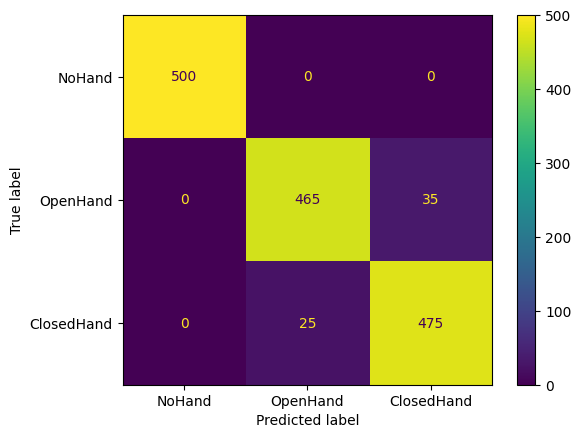

In [4]:
# Load the ONNX model
sess = onnxruntime.InferenceSession("hand_with_dropout.onnx")
intput_name = sess.get_inputs()[0].name
outputs = sess.get_outputs()
output_one = outputs[0].name
output_two = outputs[1].name

accuracy = 0
mae_x = 0
mae_y = 0
Tp = np.array([0, 0, 0])
Fp = np.array([0, 0, 0])
Fn = np.array([0, 0, 0])

all_predicted_classes = []

for i in range(len(data)):
    test_image = i
    image = data[test_image].astype(np.float32)
    prediction = sess.run(output_names=[output_one, output_two], input_feed={intput_name: image.reshape(1,256,256,3)})
    predictedClass = np.argmax(prediction[0])
    all_predicted_classes.append(predictedClass)
    mae_x += abs(labels_pos[test_image][0] - prediction[1][0][0])
    mae_y += abs(labels_pos[test_image][1] - prediction[1][0][1])
    if predictedClass == labels_ges[test_image]:
        accuracy += 1
        Tp[predictedClass] += 1
    else:
        Fp[predictedClass] += 1
        Fn[labels_ges[test_image]] += 1



accuracy = accuracy/len(data)
precision = Tp/(Tp + Fp)
recall = Tp/(Tp + Fn)
F1 = 2 * Tp/(2 * Tp + Fp + Fn)
mae_x = mae_x/len(data)
mae_y = mae_y/len(data)
mae_average = (mae_x + mae_y)/2
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", F1)
print("MAE X: ", mae_x)
print("MAE Y: ", mae_y)
print("MAE Average: ", mae_average)

cm = confusion_matrix(labels_ges, all_predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

In [71]:
# img = image.copy()
# for x in range(256):
#     for y in range(256):
#         if((x - onnx_predicted_label[1][0][0])**2 + (y - onnx_predicted_label[1][0][1])**2 < 10):
#             img[y][x] = [0, 255, 0]

# plt.imshow(img)
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
[array([[5.3064954e-01, 4.6922573e-01, 1.2471495e-04]], dtype=float32), array([[ 53.27709, 137.33081]], dtype=float32)]


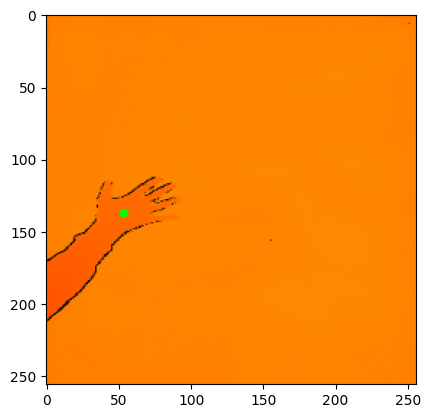

In [29]:
error = 0
for i in range(len(data)):
    test_image = i
    image = data[test_image].astype(np.float32)
    prediction = sess.run(output_names=[output_one, output_two], input_feed={intput_name: image.reshape(1,256,256,3)})
    predictedClass = np.argmax(prediction[0])
    all_predicted_classes.append(predictedClass)
    if (predictedClass != labels_ges[test_image]):
        error += 1
    if (error > 29):
        break

img = image.copy()
for x in range(256):
    for y in range(256):
        if((x - prediction[1][0][0])**2 + (y - prediction[1][0][1])**2 < 10):
            img[y][x] = [0, 255, 0]
print(predictedClass)
print(prediction)
plt.imshow(img)